<a id='qaoa-workflow-demo'></a>

# First steps: An example workflow

This section provides a walkthrough of a simple example workflow, and is intended as a quick introduction to the functionalities of the EntropicaQAOA package. More elaborate examples are provided in other sections of the documentation.

## Contents
1. [Creating the problem instance](#creating_a_hamiltonian)
2. [Setting up the parameters](#setup_parameters)
3. [Creating a cost function](#cost_function)
4. [Optimising the paramters](#optimisation)
5. [An alternative parametrisation](#outlook)

When running the code in any of these documentation files, you will need to start Rigetti's Wavefunction Simulator and the Quil Compiler by typing `qvm -S` and `quilc -S` in two open and disposable terminal windows. Assuming you have previously installed the Forest SDK, the Quantum Virtual Machine will then open in the background. More information on installing and running the QVM can be found in Rigetti's __[Forest documentation](http://docs.rigetti.com/en/stable/start.html)__. 

To begin, we import all the neccesary bits and pieces:

In [1]:
# The usual combination of numpy, matplotlib and scipy.optimize.minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# The neccesary pyquil modules
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.unitary_tools import lifted_pauli

# The QAOAParameters that we want to demo
from entropica_qaoa.qaoa.parameters import (AbstractParams,
                                            StandardParams,
                                            ExtendedParams,
                                            QAOAParameterIterator)

# import VQE and cost function modules
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim

# import utilities for conversion between graphs and hamiltonians
from entropica_qaoa.utilities import (hamiltonian_from_graph,
                                      random_k_regular_graph,
                                      plot_graph,
                                      plot_probabilities)

# supress warnings from networkx
import warnings
warnings.filterwarnings('ignore')

<a id='creating_a_hamiltonian'></a>

## Creating  a problem instance

We begin by setting up a simple problem instance. We will demonstrate how to use QAOA to solve the MaxCut problem on a graph with three nodes and weighted edges. We can create the graph as follows: 

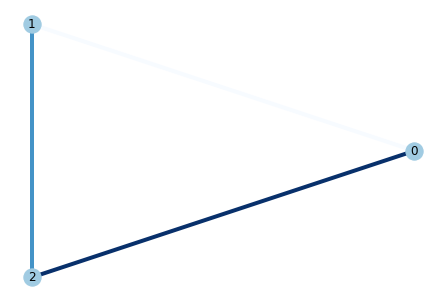

In [2]:
graph = random_k_regular_graph(degree=2, nodes=range(3), seed=42, weighted=True, biases=True)
plot_graph(graph)

The function `random_k_regular_graph` is one of several utility methods we provide. This also illustrates how EntropicaQAOA directly integrates functionality from the `NetworkX` package for graph analysis. For more information on NetworkX, refer to its documentation  __[here](https://networkx.github.io/documentation/stable/)__.

To solve the MaxCut problem for this graph using QAOA, we have to translate the graph to a Hamiltonian, which corresponds to the cost function. We can readily achieve this conversion using the `hamiltonian_from_graph` method:

In [3]:
hamiltonian = hamiltonian_from_graph(graph)
print(hamiltonian)

(0.5986584841970366+0j)*Z0 + (0.15601864044243652+0j)*Z1 + (0.15599452033620265+0j)*Z2 + (0.3745401188473625+0j)*Z0*Z1 + (0.9507143064099162+0j)*Z0*Z2 + (0.7319939418114051+0j)*Z1*Z2



**Further documentation**

More information on the creation of hamiltonians and graphs is provided in `QAOAUtilities.ipynb`.

<a id='setup_parameters'></a>
## Specifying the parameters to be optimised: the QAOA Parameter classes

Having established the problem Hamiltonian, we next set up our chosen circuit parametrisation. There are a range of different choices available in EntropicaQAOA, which are demonstrated in detail in `2_ParameterClasses.ipynb` and `3_AdvancedParameterClasses.ipynb`. 

For this Notebook we will use the `StandardParams` parametrisation. As the name suggests, this corresponds to the most commonly used parametrisation, and is the one originally introduced by Farhi et al in [Ref 1](#references). Here, the mixer and cost Hamiltonians each have one angle per timestep, giving a total of $2p$ parameters to optimise over.

In this example, we will choose $p=2$, and initalise the angles `gammas` and `betas` with simple (but uninspired!) values. Besides the initial values of these angles, we must also provide the problem *hyperparameters*, which, unlike the `gammas` and `betas`, are unchanged throughout the optimisation procedure. The hyperparameters here are the Hamiltonian, and the number of timesteps $p$. 

In [4]:
timesteps = 2 # this is the usual QAOA p parameter
hyperparameters = (hamiltonian, timesteps)

# Specify some angles. We have p=2, so we need two betas and two gammas
betas = [0.1, 0.6]
gammas = [0.4, 0.5]
parameters = (betas, gammas)

standard_params = StandardParams(hyperparameters, parameters)
print(standard_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0, 1, 2]
	qubits_pairs: [[0, 1], [0, 2], [1, 2]]
Parameters:
	betas: [0.1 0.6]
	gammas: [0.4 0.5]



**Further documentation**

To learn all about the different parametrisations, the various ways to create parameter objects automatically, and how to manipulate them, refer to `2_ParameterClasses.ipynb`

<a id='cost_function'></a>

## Creating the cost function

With the problem and our parametrisation now defined, we next create a cost function that we can pass to a minimiser of our choice (e.g. `scipy.optimize.minimize`). To work seamlessly with most typical optimisers, this cost function needs to take in an array of values (the initial values of the parameters we want to optimise), and output a single number (the corresponding value of the objective function). We provide two such classes of cost functions for the QAOA: `QAOACostFunctionOnWFSim`, which is used with the Wavefunction Simulator; and `QAOACostFunctionOnQVM`, which is used with a QVM or QPU. For the purposes of this example we will use the Wavefunction Simulator, since it is faster and returns exact expectation values (as opposed to sampled estimates of it).

In [5]:
# set up the cost function
cost_function = QAOACostFunctionOnWFSim(hamiltonian, params=standard_params)

**Implementation note and further documentation**

It may seem somewhat unconventional that one should need to specify parameters (such as `standard_params` above) to construct a cost function. However, this design choice simplifies the conversion of the input variable parameters to the actual rotation angles that are executed in the quantum circuit. Moreover, one is unlikely to be working with a cost function object in isolation: for optimisation, a set of parameters is always created at the same time to pass into the cost function. 

Note also that it is not necessary to actually specify values for the angles, as we have done above. We provide several methods for automatically setting up parameter values, as demonstrated in `2_ParameterClasses.ipynb`.

In `4_CostFunctionsAndVQE.ipynb` we demonstrate the usage of `QAOACostFunctionOnQVM`. This also showcases more advanced usages of the cost functions, including how to make logs of the function calls, and how to introduce fake sampling noise for more realistic simulations of QAOA.

<a id='optimisation'></a>

## Optimising the parameters

Now that we have a cost function and some initial parameters, we can use a minimiser of our choice – in this case `scipy.optimize.minimize` – to optimise the parameters:

In [6]:
res = minimize(cost_function, standard_params.raw(), tol=1e-3,
               options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.1381074861256129
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 80
  status: 1
 success: True
       x: array([0.5075231 , 0.2640147 , 0.41118043, 0.85510375])

We can check this against the exact value by finding the lowest eigenvalue of `hamiltonian`.

In [7]:
ham_matrix = lifted_pauli(hamiltonian, hamiltonian.get_qubits())
eigs = np.linalg.eigvals(ham_matrix)
min(eigs)

(-1.9068507336772291+0j)

Evidently, we have not found the ground state exactly. We can examine the probability of measuring each energy eigenstate, along with the corresponding energies, as follows:

- Obtain the output wavefunction using `cost_function.get_wavefunction()`
- Generate a bar plot to compare the energies of each of the states and their respective probabilities. We do this using the`plot_probabilities()` method, contained in `entropica_qaoa.utilities`. This produces a plot of the negative of each energy (i.e. each energy multiplied by $-1$), side by side with the probability. States with high values of $-1\times energy$ should therefore coincide with high probabilities.

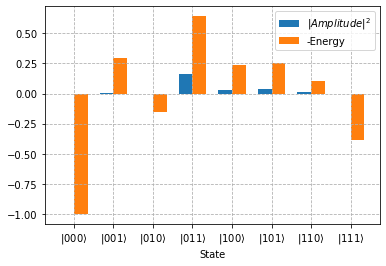

In [8]:
probabilities = cost_function.get_wavefunction(standard_params.raw()).probabilities()
energies = np.diag(ham_matrix)

plot_probabilities(probabilities, energies)

Evidently the state with the lowest energy (largest negative energy) corresponds to the state with the largest measurement probability, however there is still some contribution from sub-optimal solutions. To do better, we can try increasing the number of timesteps to $p=3$:

In [9]:
betas          = [0.1, 0.6, 0.8]
gammas_singles = [0.4, 0.5, 0.6]
gammas_pairs   = [0.1, 0.3, 0.5]
parameters = (betas, gammas_singles, gammas_pairs)

standard_params_p3 = StandardParams([hamiltonian,3],parameters)

cost_function = QAOACostFunctionOnWFSim(hamiltonian,params=standard_params_p3)

res = minimize(cost_function, standard_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.314786957284364
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 158
  status: 1
 success: True
       x: array([0.56818343, 0.50366739, 0.28841164, 0.45952564, 0.84483075,
       0.88324141])

This is an improvement, but still not the actual ground state. The following section gives a brief introduction to the use of an alternate parametrisation, `ExtendedParams`, which is more expressive, and hence may naively be expected to give better results.

<a id='outlook'></a>
## An alternative parametrisation

Here we will set up `ExtendedParams` directly from our existing set of `StandardParams`, making use of EntropicaQAOA's parameter conversion methods.

In [10]:
extended_params_p3 = ExtendedParams.from_other_parameters(standard_params_p3)

cost_function = QAOACostFunctionOnWFSim(hamiltonian,params=extended_params_p3)

res = minimize(cost_function, extended_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.8970669808663276
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 500
  status: 2
 success: False
       x: array([ 0.33606758,  0.10134483,  0.92856431,  0.71982022,  0.50953751,
        0.95264686,  0.26597692,  0.33826225,  0.65283808,  0.47696191,
        2.09234295, -0.11489466,  0.96109444,  2.42346351,  0.17229808,
        0.67969652,  2.19743182,  2.12489277,  0.27564749,  0.48927321,
        0.47138807,  0.98226176,  0.75037525,  0.63263085,  0.70727788,
        0.85679038,  0.60966477])

Clearly now we have found a much better ground state energy. The result attribute `x` is a list of the optimal circuit parameters that have been found. We can disentangle this into the `betas` and `gammas` of our QAOA parameterisation by using the `update_from_raw()` method:

In [11]:
extended_params_p3.update_from_raw(res['x'])
extended_params_p3

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0, 1, 2]
	qubits_pairs: [[0, 1], [0, 2], [1, 2]]
Parameters:
	betas: [[0.33606758 0.10134483 0.92856431], [0.71982022 0.50953751 0.95264686], [0.26597692 0.33826225 0.65283808]]
	gammas_singles: [[ 0.47696191  2.09234295 -0.11489466], [ 0.96109444  2.42346351  0.17229808], [ 0.67969652  2.19743182  2.12489277]]
	gammas_pairs: [[0.27564749 0.48927321 0.47138807], [0.98226176 0.75037525 0.63263085], [0.70727788 0.85679038 0.60966477]]

Now that we have the optimal angles, we can prepare the corresponding state and sample from it to obtain the most probable bitstring. 

In this notebook we are using the wavefunction simulator, which allows us to 'cheat' and easily obtain any observable quantity without the need to sample. We use the `get_wavefunction` method of the `cost_function` to obtain the wavefunction, then compute the corresponding probabilities, and plot a bar graph of the outcomes:

In [12]:
opt_wfn = cost_function.get_wavefunction(res.x)
print(opt_wfn)

(-0.00716914+0.0018323639j)|000> + (0.0063983618+0.0119885383j)|001> + (-0.0007095101-0.0008425164j)|010> + (0.1794862787+0.9796596921j)|011> + (0.065484157+0.0103568406j)|100> + (0.0403429137+0.041279573j)|101> + (0.0047927286+0.0007375605j)|110> + (0.007280748+0.0027231625j)|111>


In [13]:
probs = opt_wfn.probabilities()
probs

array([5.47541258e-05, 1.84664083e-04, 1.21323848e-06, 9.91948437e-01,
       4.39543897e-03, 3.33155383e-03, 2.35142433e-05, 6.04249059e-05])

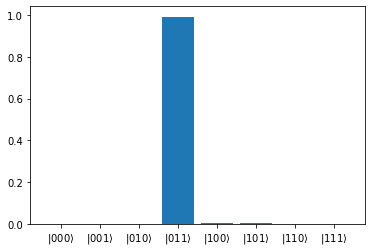

In [14]:
labels = [r'$\left|{0:03b}\right>$'.format(i) for i in range(8)]
plt.bar(range(8),probs)
plt.xticks(range(8), labels);

The QAOA has determined that the bitstring 011 (the number 3 in decimal) is the minimum energy solution with essentially unit probability. Let's check this is consistent with the real answer:

In [15]:
np.linalg.eig(ham_matrix)

(array([ 2.96792001+0.j, -0.87990581+0.j,  0.44281461+0.j, -1.90685073+0.j,
        -0.70948553+0.j, -0.75445412+0.j, -0.30661516+0.j,  1.14657672+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

The lowest energy solution does indeed correspond to the eigenvector $(0,0,0,1,0,0,0,0)$, i.e. the $|011\rangle$ component. 

Suppose that we return to the original Hamiltonian, but instead we remove the single-qubit bias terms. Let's run the computation again and see what result we find. This time we'll set up `ExtendedParams` using the `empty()` method, which means we don't need to explicitly provide initial values for the `gammas` and `betas`.

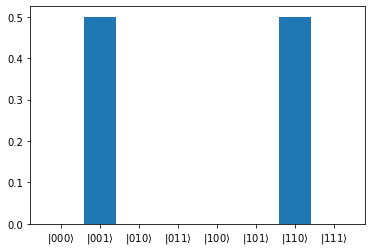

In [16]:
term1 = PauliTerm("Z", 0, 0.7) * PauliTerm("Z", 1)
term2 = PauliTerm("Z", 0, 1.2) * PauliTerm("Z", 2)

hamiltonian_unbiased = PauliSum([term1, term2])
n_steps = 2

params_unbiased = ExtendedParams.empty((hamiltonian_unbiased,n_steps))

cost_function_unbiased = QAOACostFunctionOnWFSim(hamiltonian_unbiased, params=params_unbiased)

res_unbiased = minimize(cost_function_unbiased,
                        np.zeros(len(params_unbiased)),
                        tol=1e-3, options={"maxiter":500},
                        method="Cobyla")

opt_wfn_unbiased = cost_function_unbiased.get_wavefunction(res_unbiased.x)
probs_unbiased = opt_wfn_unbiased.probabilities()

labels = [r'$\left|{0:03b}\right>$'.format(i) for i in range(8)]
plt.bar(range(8),probs_unbiased)
plt.xticks(range(8), labels);

Now the probabilities are completely symmetric under a bit flip on all qubits - there is no bias term in the Hamiltonian to force a given qubit into state $|0\rangle$ or $|1\rangle$, and the eigenspectrum of the cost function Hamiltonian is "doubly degenerate", i.e. the energy eigenstates fall into pairs, where the corresponding eigenstates are related to one another by a bit flip on all qubits. 

**Further documentation**

Further information and examples of setting up the different types of parameters may be found in `QAOAParameterDemo` and `AdvancedQAOAParameterDemo`.

<a id='references'></a>

## References

1. E. Farhi et al, __[*A Quantum Approximate Optimization Algorithm*](https://arxiv.org/abs/1411.4028)__